In [1]:
import csv
import pprint

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'keypoint-dataset.csv'
model_save_path = 'tflite/keypoint_classifier.hdf5'
tflite_save_path = 'tflite/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 9

# Dataset reading

In [4]:
# Take the coordinates as X
X_dataset = pd.read_csv(dataset, delimiter=',').iloc[:, 1:35]

# Take the classes as Y
y_dataset = pd.read_csv(dataset, delimiter=',').iloc[:, 0] 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED, stratify=y_dataset)
print(X_dataset.shape)
print(y_dataset.shape)

(285, 34)
(285,)


# Model building

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None, 34)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [7]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, None, 34)          0         
                                                                 
 dense (Dense)               (None, None, 20)          700       
                                                                 
 dropout_1 (Dropout)         (None, None, 20)          0         
                                                                 
 dense_1 (Dense)             (None, None, 10)          210       
                                                                 
 dense_2 (Dense)             (None, None, 9)           99        
                                                                 
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [9]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [10]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 0s - loss: 2.3383 - accuracy: 0.0938
Epoch 1: saving model to tflite\keypoint_classifier.hdf5
2/2 [==============================] - 1s 172ms/step - loss: 2.3432 - accuracy: 0.1080 - val_loss: 2.2296 - val_accuracy: 0.2361
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 2.3357 - accuracy: 0.0781
Epoch 2: saving model to tflite\keypoint_classifier.hdf5
2/2 [==============================] - 0s 36ms/step - loss: 2.3340 - accuracy: 0.1080 - val_loss: 2.2033 - val_accuracy: 0.2639
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 2.2732 - accuracy: 0.1562
Epoch 3: saving model to tflite\keypoint_classifier.hdf5
2/2 [==============================] - 0s 37ms/step - loss: 2.2780 - accuracy: 0.1362 - val_loss: 2.1789 - val_accuracy: 0.2639
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 2.2705 - accuracy: 0.1406
Epoch 4: saving model to tflite\keypoint_classifier.hdf5
2/2 [======

In [11]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 16ms/step - loss: 0.0246 - accuracy: 1.0000


In [12]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)
print(X_test.shape)

(72, 34)


In [13]:
# Inference test
predict_result = model.predict(np.array([X_test]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 94ms/step
[[9.88660693e-01 1.12335272e-02 2.78881647e-08 1.21990922e-07
  1.21465400e-05 1.36450190e-05 3.08885433e-07 1.72737600e-05
  6.22534499e-05]
 [5.71819604e-04 9.99426246e-01 5.00242026e-09 2.83079174e-07
  2.00851517e-07 2.96439850e-07 2.23332073e-08 3.84316508e-08
  1.24004066e-06]
 [2.02024309e-03 9.97975409e-01 1.55150115e-08 3.95463957e-07
  2.56978950e-07 3.01474103e-07 8.52405009e-08 1.81045735e-07
  3.07663140e-06]
 [9.90382254e-01 9.52678360e-03 2.20808936e-08 9.68461222e-08
  1.01773030e-05 1.15684143e-05 2.51053677e-07 1.47800656e-05
  5.41181726e-05]
 [6.98540406e-03 9.93004143e-01 4.24755981e-08 7.45746206e-07
  5.69778649e-07 6.66089818e-07 1.99921672e-07 4.73315907e-07
  7.67194615e-06]
 [9.87824559e-01 1.20659694e-02 2.92021625e-08 1.28640949e-07
  1.27412077e-05 1.42081244e-05 3.20717049e-07 1.77817637e-05
  6.43444000e-05]
 [9.99891996e-01 1.08035347e-04 5.25716013e-14 3.46559858e-13
  1.32793432e-09 1.44057677e-09 3.

# Confusion matrix

3/3 [==============================] - 0s 1ms/step


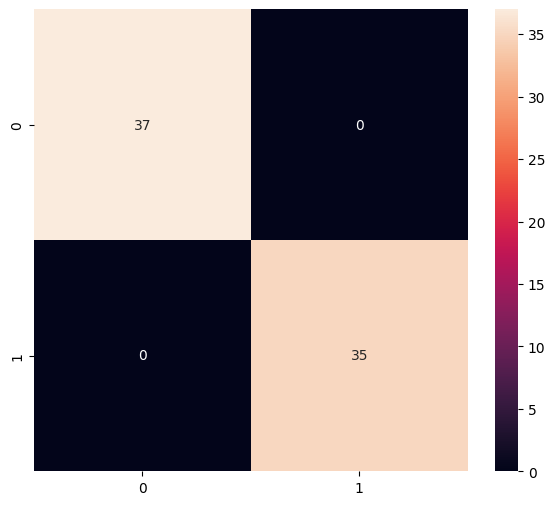

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        35

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [15]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [16]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\bashu\AppData\Local\Temp\tmp4bd9r7_8\assets


INFO:tensorflow:Assets written to: C:\Users\bashu\AppData\Local\Temp\tmp4bd9r7_8\assets


11548

# Inference test

In [17]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [18]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
interpreter.set_tensor(input_details[0]['index'], np.array([[X_test[0]]]))

KeyError: 0

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))